In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from torch import nn
from torch.autograd import Variable
import pdb

import torch

import pandas as pd
import seaborn as sns
sns.set_style('white')

# Alpha and beta control class-specific error rates; 
# alpha is the  false negative rate
# beta is the false positive rate
# I create classifiers with certain FNRs / FPRs but simulating different alphas & betas on the train set

def apply_alpha_beta(y, alpha_opt, beta_opt):
    t = y.copy()
    for label in [0, 1]:
        n_examples = (t == label).sum()
        swap_rate = alpha_opt if label == 0 else beta_opt
        swap_idxs = np.random.choice(np.where(t == label)[0], size=int(swap_rate * n_examples), replace=False)
        t[swap_idxs] = 1 - label
    return t

def inv_sigm(y):
    return np.log(y / (1 - y))

def gibbs_classification(model, x):
    p_y = model.predict_proba(x)[:,1]
    samples = np.random.random(p_y.shape)
    return (samples  < p_y).astype(int)

def get_agreements(*tests):
    # tests are binary outputs from classifiers
    # This function calculates the number of agreements between the classifiers
    # for all possible combinations of positive and negative results
    
    # Initialize a dictionary to store the results
    agreements = {}
    
    # Get the indices of positive and negative results for each test
    pos_indices = [np.where(test == 1)[0] for test in tests]
    neg_indices = [np.where(test == 0)[0] for test in tests]
    
    # Calculate the number of agreements for all combinations
    for i in range(2 ** len(tests)):
        # Convert the combination to binary and pad with zeros
        combination = bin(i)[2:].zfill(len(tests))
        
        # Get the indices for this combination
        indices = [pos_indices[j] if combination[j] == '1' else neg_indices[j] for j in range(len(tests))]
        
        # Calculate the number of agreements
        agreements[combination] = len(set(indices[0]).intersection(*indices[1:]))
    
    return agreements

'''
def get_agreements(tA, tB, tC):
    # tA, tB, and tC are binary outputs from classifiers  A, B, and C respectively
    tA_pos = np.where(tA == 1)[0]
    tA_neg = np.where(tA == 0)[0]
    tB_pos = np.where(tB == 1)[0]
    tB_neg = np.where(tB == 0)[0]
    tC_pos = np.where(tC == 1)[0]
    tC_neg = np.where(tC == 0)[0]
    n_tA_pos, n_tA_neg = len(tA_pos), len(tA_neg)
    n_tB_pos, n_tB_neg = len(tB_pos), len(tB_neg)

    n_pos_pos_pos = len(set(tA_pos).intersection(tB_pos).intersection(tC_pos))
    n_pos_pos_neg = len(set(tA_pos).intersection(tB_pos).intersection(tC_neg))

    n_pos_neg_pos = len(set(tA_pos).intersection(tB_neg).intersection(tC_pos))
    n_pos_neg_neg = len(set(tA_pos).intersection(tB_neg).intersection(tC_neg))

    n_neg_pos_pos = len(set(tA_neg).intersection(tB_pos).intersection(tC_pos))
    n_neg_pos_neg = len(set(tA_neg).intersection(tB_pos).intersection(tC_neg))

    n_neg_neg_pos = len(set(tA_neg).intersection(tB_neg).intersection(tC_pos))
    n_neg_neg_neg = len(set(tA_neg).intersection(tB_neg).intersection(tC_neg))
    
    return n_pos_pos_pos, n_pos_pos_neg, n_pos_neg_pos, n_pos_neg_neg, n_neg_pos_pos, n_neg_pos_neg, n_neg_neg_pos, n_neg_neg_neg
'''


ModuleNotFoundError: No module named 'numpy'

## Testing Hui & Walter Method on completely synthetic data

In [6]:
true_alpha1, true_beta1 = .3, .1
true_alpha2, true_beta2 = .2, .1
true_alpha3, true_beta3 = .2, .5
true_theta1, true_theta2 = .3, .6

n_examples = 10000
y1 = np.concatenate([np.ones((int(true_theta1*n_examples))), np.zeros((int((1-true_theta1)*n_examples)))])
y2 = np.concatenate([np.ones((int(true_theta2*n_examples))), np.zeros((int((1-true_theta2)*n_examples)))])

tA_1 = apply_alpha_beta(y1, true_alpha1, true_beta1)
tA_2 = apply_alpha_beta(y2, true_alpha1, true_beta1)

tB_1 = apply_alpha_beta(y1, true_alpha2, true_beta2)
tB_2 = apply_alpha_beta(y2, true_alpha2, true_beta2)

tC_1 = apply_alpha_beta(y1, true_alpha3, true_beta3)
tC_2 = apply_alpha_beta(y2, true_alpha3, true_beta3)

In [7]:
# Two tests, two populations
n_epochs = 10000
log_interval = 1000

alpha1_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
alpha2_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
beta1_v = Variable(torch.Tensor([inv_sigm(.9)]), requires_grad=True)
beta2_v = Variable(torch.Tensor([inv_sigm(.9)]), requires_grad=True)
theta1_v = Variable(torch.Tensor([inv_sigm(.9)]), requires_grad=True)
theta2_v = Variable(torch.Tensor([inv_sigm(.3)]), requires_grad=True)

tA_1_pos = np.where(tA_1 == 1)[0]
tA_1_neg = np.where(tA_1 == 0)[0]
tB_1_pos = np.where(tB_1 == 1)[0]
tB_1_neg = np.where(tB_1 == 0)[0]
n_tA_1_pos, n_tA_1_neg = len(tA_1_pos), len(tA_1_neg)
n_tB_1_pos, n_tB_1_neg = len(tB_1_pos), len(tB_1_neg)

n_pos_pos_1 = len(set(tA_1_pos).intersection(tB_1_pos))
n_pos_neg_1 = len(set(tA_1_pos).intersection(tB_1_neg))
n_neg_pos_1 = len(set(tA_1_neg).intersection(tB_1_pos))
n_neg_neg_1 = len(set(tA_1_neg).intersection(tB_1_neg))

tA_2_pos = np.where(tA_2 == 1)[0]
tA_2_neg = np.where(tA_2 == 0)[0]
tB_2_pos = np.where(tB_2 == 1)[0]
tB_2_neg = np.where(tB_2 == 0)[0]
n_tA_2_pos, n_tA_2_neg = len(tA_2_pos), len(tA_2_neg)
n_tB_2_pos, n_tB_2_neg = len(tB_2_pos), len(tB_2_neg)

n_pos_pos_2 = len(set(tA_2_pos).intersection(tB_2_pos))
n_pos_neg_2 = len(set(tA_2_pos).intersection(tB_2_neg))
n_neg_pos_2 = len(set(tA_2_neg).intersection(tB_2_pos))
n_neg_neg_2 = len(set(tA_2_neg).intersection(tB_2_neg))

print(n_pos_pos_1, n_pos_neg_1, n_neg_pos_1, n_neg_neg_1)
print(n_pos_pos_2, n_pos_neg_2, n_neg_pos_2, n_neg_neg_2)


learning_rate = .01
optim = torch.optim.Adam([theta1_v, theta2_v, beta2_v, beta1_v, alpha2_v, alpha1_v], lr = learning_rate)
losses, beta2s = [], []

for epoch in range(n_epochs):
    optim.zero_grad()
    alpha1, alpha2 = torch.sigmoid(alpha1_v), torch.sigmoid(alpha2_v)
    beta1, beta2 = torch.sigmoid(beta1_v), torch.sigmoid(beta2_v)
    theta1, theta2 = torch.sigmoid(theta1_v), torch.sigmoid(theta2_v)
    n_1 = len(tA_1)
    n_2 = len(tA_2)
    l = n_pos_pos_1*torch.log(((theta1 * (1-beta1) * (1 - beta2)) + ((1-theta1)*alpha1*alpha2)))/n_1
    l += n_pos_neg_1*torch.log((theta1*(1-beta1)*beta2) + ((1-theta1)*alpha1*(1-alpha2)))/n_1
    l += n_neg_pos_1*torch.log(theta1*beta1*(1-beta2) +  (1-theta1)*(1-alpha1)*alpha2)/n_1
    l += n_neg_neg_1*torch.log(theta1*beta1*beta2 + (1-theta1)*(1-alpha1)*(1-alpha2))/n_1

    l += n_pos_pos_2*torch.log(((theta2 * (1-beta1) * (1 - beta2)) + ((1-theta2)*alpha1*alpha2)))/n_2
    l += n_pos_neg_2*torch.log((theta2*(1-beta1)*beta2) + ((1-theta2)*alpha1*(1-alpha2)))/n_2
    l += n_neg_pos_2*torch.log(theta2*beta1*(1-beta2) +  (1-theta2)*(1-alpha1)*alpha2)/n_2
    l += n_neg_neg_2*torch.log(theta2*beta1*beta2 + (1-theta2)*(1-alpha1)*(1-alpha2))/n_2
    
    loss = -l
    loss.backward()
    
    optim.step()
    if  epoch % log_interval == 0:
        print("Test A alpha: ", alpha1.item(), "\tbeta: ", beta1.item())
        print("Test B alpha: ", alpha2.item(), "\tbeta: ", beta2.item())
        print("Theta1: ", theta1.item(), "Theta2: ", theta2.item())
        print()
    beta2s.append(beta2.item())
    losses.append(loss.item())


2835 1965 1265 3935
5080 1520 1120 2280
Test A alpha:  0.10000000149011612 	beta:  0.8999999761581421
Test B alpha:  0.10000000149011612 	beta:  0.8999999761581421
Theta1:  0.8999999761581421 Theta2:  0.30000001192092896

Test A alpha:  0.18778540194034576 	beta:  0.1925613284111023
Test B alpha:  0.11461319029331207 	beta:  0.23103028535842896
Theta1:  0.46214595437049866 Theta2:  0.7470922470092773

Test A alpha:  0.26472848653793335 	beta:  0.14477919042110443
Test B alpha:  0.16014008224010468 	beta:  0.153035506606102
Theta1:  0.36046701669692993 Theta2:  0.6670026779174805

Test A alpha:  0.28977373242378235 	beta:  0.11680442839860916
Test B alpha:  0.18973974883556366 	beta:  0.12126634269952774
Theta1:  0.3183538615703583 Theta2:  0.6243534088134766

Test A alpha:  0.29853931069374084 	beta:  0.10670668631792068
Test B alpha:  0.19908712804317474 	beta:  0.10875282436609268
Theta1:  0.3044331967830658 Theta2:  0.6080788969993591

Test A alpha:  0.30107513070106506 	beta:  0.10

In [8]:
# Three tests, one population
n_epochs = 10000
log_interval = 1000

alpha1_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
alpha2_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
alpha3_v = Variable(torch.Tensor([inv_sigm(.832)]), requires_grad=True)
beta1_v = Variable(torch.Tensor([inv_sigm(.9)]), requires_grad=True)
beta2_v = Variable(torch.Tensor([inv_sigm(.9)]), requires_grad=True)
beta3_v = Variable(torch.Tensor([inv_sigm(.3)]), requires_grad=True)
theta1_v = Variable(torch.Tensor([inv_sigm(1/3)]), requires_grad=True)

tA_1_pos = np.where(tA_1 == 1)[0]
tA_1_neg = np.where(tA_1 == 0)[0]
tB_1_pos = np.where(tB_1 == 1)[0]
tB_1_neg = np.where(tB_1 == 0)[0]
tC_1_pos = np.where(tC_1 == 1)[0]
tC_1_neg = np.where(tC_1 == 0)[0]
n_tA_1_pos, n_tA_1_neg = len(tA_1_pos), len(tA_1_neg)
n_tB_1_pos, n_tB_1_neg = len(tB_1_pos), len(tB_1_neg)

n_pos_pos_pos_1 = len(set(tA_1_pos).intersection(tB_1_pos).intersection(tC_1_pos))
n_pos_pos_neg_1 = len(set(tA_1_pos).intersection(tB_1_pos).intersection(tC_1_neg))

n_pos_neg_pos_1 = len(set(tA_1_pos).intersection(tB_1_neg).intersection(tC_1_pos))
n_pos_neg_neg_1 = len(set(tA_1_pos).intersection(tB_1_neg).intersection(tC_1_neg))

n_neg_pos_pos_1 = len(set(tA_1_neg).intersection(tB_1_pos).intersection(tC_1_pos))
n_neg_pos_neg_1 = len(set(tA_1_neg).intersection(tB_1_pos).intersection(tC_1_neg))

n_neg_neg_pos_1 = len(set(tA_1_neg).intersection(tB_1_neg).intersection(tC_1_pos))
n_neg_neg_neg_1 = len(set(tA_1_neg).intersection(tB_1_neg).intersection(tC_1_neg))

print(n_pos_pos_pos_1, n_pos_neg_pos_1, n_neg_pos_pos_1, n_neg_neg_pos_1)
print(n_pos_pos_neg_1, n_pos_neg_neg_1, n_neg_pos_neg_1, n_neg_neg_neg_1)


learning_rate = .01
optim = torch.optim.Adam([theta1_v, beta3_v, beta2_v, beta1_v, alpha3_v, alpha2_v, alpha1_v], lr = learning_rate)

losses, beta2s = [], []
for epoch in range(n_epochs):

    optim.zero_grad()
    alpha1, alpha2, alpha3 = torch.sigmoid(alpha1_v), torch.sigmoid(alpha2_v), torch.sigmoid(alpha3_v)
    beta1, beta2, beta3 = torch.sigmoid(beta1_v), torch.sigmoid(beta2_v), torch.sigmoid(beta3_v)
    theta1 = torch.sigmoid(theta1_v)
    n_1 = len(tA_1)
    n_2 = len(tA_2)
    l = n_pos_pos_pos_1*torch.log(((theta1 * (1-beta1) * (1-beta2) * (1-beta3)) + ((1-theta1)*alpha1*alpha2*alpha3)))/n_1
    l += n_pos_pos_neg_1*torch.log(((theta1 * (1-beta1) * (1-beta2) * (beta3)) + ((1-theta1)*alpha1*alpha2*(1-alpha3))))/n_1

    l += n_pos_neg_pos_1*torch.log((theta1*(1-beta1)*beta2*(1-beta3)) + ((1-theta1)*alpha1*(1-alpha2)*alpha3))/n_1
    l += n_pos_neg_neg_1*torch.log((theta1*(1-beta1)*beta2*(beta3)) + ((1-theta1)*alpha1*(1-alpha2)*(1-alpha3)))/n_1

    l += n_neg_pos_pos_1*torch.log(theta1*beta1*(1-beta2)*(1-beta3) +  (1-theta1)*(1-alpha1)*alpha2*alpha3)/n_1
    l += n_neg_pos_neg_1*torch.log(theta1*beta1*(1-beta2)*(beta3) +  (1-theta1)*(1-alpha1)*alpha2*(1-alpha3))/n_1
    
    l += n_neg_neg_pos_1*torch.log(theta1*beta1*beta2*(1-beta3) + (1-theta1)*(1-alpha1)*(1-alpha2)*alpha3)/n_1
    l += n_neg_neg_neg_1*torch.log(theta1*beta1*beta2*beta3 + (1-theta1)*(1-alpha1)*(1-alpha2)*(1-alpha3))/n_1

    
    loss = -l
    loss.backward()
    
    optim.step()
    if  epoch % log_interval == 0:
        print("Test A alpha: ", alpha1.item(), "\tbeta: ", beta1.item())
        print("Test B alpha: ", alpha2.item(), "\tbeta: ", beta2.item())
        print("Test C alpha: ", alpha3.item(), "\tbeta: ", beta3.item())
        print("Theta1: ", theta1.item())
        print()
    beta2s.append(beta2.item())
    losses.append(loss.item())

print("True A alpha1: ",np.mean(tA_1[y1 == 0]), '\t beta: ', 1-np.mean(tA_1[y1 == 1]))
print("True B alpha2: ", np.mean(tB_1[y1 == 0]), '\t beta: ',  1 - np.mean(tB_1[y1 == 1]))
print("True C alpha2: ", np.mean(tC_1[y1 == 0]), '\t betat: ',  1 - np.mean(tC_1[y1 == 1]))

print("True theta1: ", np.mean(y1))

1304 443 314 839
1531 1522 951 3096
Test A alpha:  0.10000000149011612 	beta:  0.8999999761581421
Test B alpha:  0.10000000149011612 	beta:  0.8999999761581421
Test C alpha:  0.8319999575614929 	beta:  0.30000001192092896
Theta1:  0.3333333432674408

Test A alpha:  0.16549690067768097 	beta:  0.31640398502349854
Test B alpha:  0.11652206629514694 	beta:  0.38648658990859985
Test C alpha:  0.20833376049995422 	beta:  0.6460244655609131
Theta1:  0.5885652303695679

Test A alpha:  0.2736150324344635 	beta:  0.17340947687625885
Test B alpha:  0.1629699319601059 	beta:  0.17351561784744263
Test C alpha:  0.18695004284381866 	beta:  0.5363795757293701
Theta1:  0.36892181634902954

Test A alpha:  0.3043733835220337 	beta:  0.10402128845453262
Test B alpha:  0.20264922082424164 	beta:  0.09817074984312057
Test C alpha:  0.20125539600849152 	beta:  0.4991602599620819
Theta1:  0.2957342267036438

Test A alpha:  0.3139350414276123 	beta:  0.07940417528152466
Test B alpha:  0.2135593593120575 	bet

## Testing on logistic regressions (introducing correlated errors)

In [9]:
# Generate x 
train_size = 20000
pos = np.random.multivariate_normal((1, 1), [[1, 1], [1, 1]], size=train_size)
neg = np.random.multivariate_normal((-1, -1), [[1, 1], [1, 1]], size=train_size)

x_train = np.concatenate([pos, neg], axis=0)
y_train = np.concatenate([np.ones(pos.shape[0]), np.zeros(neg.shape[0])], axis=0)

# Train Model 1 
mA_alpha, mA_beta = .2, .1
xA_train, yA_train = x_train.copy(), apply_alpha_beta(y_train, mA_alpha, mA_beta)
lrA = LogisticRegression(penalty='none')
lrA.fit(xA_train, yA_train)

# Train Model 2 
mB_alpha, mB_beta = .3, .1
xB_train, yB_train = x_train.copy(), apply_alpha_beta(y_train, mB_alpha, mB_beta)
lrB = LogisticRegression(penalty='none')
lrB.fit(xB_train, yB_train)

# Train Model 3
mC_alpha, mC_beta = .3, .2
xC_train, yC_train = x_train.copy(), apply_alpha_beta(y_train, mC_alpha, mC_beta)
lrC = LogisticRegression(penalty='none')
lrC.fit(xC_train, yC_train)

LogisticRegression(penalty='none')

In [10]:
# Create two test populations
n_samples = 10000
pos_1 = np.random.multivariate_normal((1, 1), [[1, 1], [1, 1]], size=n_samples)
neg_1 = np.random.multivariate_normal((-1, -1), [[1, 1], [1, 1]], size=2*n_samples)

pos_2 = np.random.multivariate_normal((1, 1), [[1, 1], [1, 1]], size=2*n_samples)
neg_2 = np.random.multivariate_normal((-1, -1), [[1, 1], [1, 1]], size=2*n_samples)

x1 = np.concatenate([pos_1, neg_1], axis=0)
y1 = np.concatenate([np.ones(n_samples), np.zeros(2*n_samples)])
x2 = np.concatenate([pos_2, neg_2], axis=0)
y2 = np.concatenate([np.ones(2*n_samples), np.zeros(2*n_samples)])


In [11]:

tA_1 = lrA.predict(x1)
tB_1 = lrB.predict(x1)
tC_1 = lrC.predict(x1)
tA_2 = lrA.predict(x2)
tB_2 = lrB.predict(x2)
tC_2 = lrC.predict(x2)


print("Test A alpha1: ",np.mean(tA_1[y1 == 0]), "\tbeta1: ", 1-np.mean(tA_1[y1 == 1]))
print("Test B alpha2: ", np.mean(tB_1[y1 == 0]), "\tbeta2: ", 1 - np.mean(tB_1[y1 == 1]))
print("Test C alpha3: ", np.mean(tC_1[y1 == 0]), "\tbeta3: ", 1 - np.mean(tC_1[y1 == 1]))

print("True theta1: ", np.mean(y1), "\tTrue theta2: ", np.mean(y2))

Test A alpha1:  0.2447 	beta1:  0.10519999999999996
Test B alpha2:  0.37395 	beta2:  0.0524
Test C alpha3:  0.27765 	beta3:  0.08679999999999999
True theta1:  0.3333333333333333 	True theta2:  0.5


In [13]:
n_epochs = 10000
log_interval = 1000

alpha1_v = Variable(torch.Tensor([inv_sigm(.36)]), requires_grad=True)
alpha2_v = Variable(torch.Tensor([inv_sigm(.42)]), requires_grad=True)
beta1_v = Variable(torch.Tensor([inv_sigm(.26)]), requires_grad=True)
beta2_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
theta1_v = Variable(torch.Tensor([inv_sigm(1/3)]), requires_grad=True)
theta2_v = Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True)

tA_1_pos = np.where(tA_1 == 1)[0]
tA_1_neg = np.where(tA_1 == 0)[0]
tB_1_pos = np.where(tB_1 == 1)[0]
tB_1_neg = np.where(tB_1 == 0)[0]
n_tA_1_pos, n_tA_1_neg = len(tA_1_pos), len(tA_1_neg)
n_tB_1_pos, n_tB_1_neg = len(tB_1_pos), len(tB_1_neg)

n_pos_pos_1 = len(set(tA_1_pos).intersection(tB_1_pos))
n_pos_neg_1 = len(set(tA_1_pos).intersection(tB_1_neg))
n_neg_pos_1 = len(set(tA_1_neg).intersection(tB_1_pos))
n_neg_neg_1 = len(set(tA_1_neg).intersection(tB_1_neg))

tA_2_pos = np.where(tA_2 == 1)[0]
tA_2_neg = np.where(tA_2 == 0)[0]
tB_2_pos = np.where(tB_2 == 1)[0]
tB_2_neg = np.where(tB_2 == 0)[0]
n_tA_2_pos, n_tA_2_neg = len(tA_2_pos), len(tA_2_neg)
n_tB_2_pos, n_tB_2_neg = len(tB_2_pos), len(tB_2_neg)

n_pos_pos_2 = len(set(tA_2_pos).intersection(tB_2_pos))
n_pos_neg_2 = len(set(tA_2_pos).intersection(tB_2_neg))
n_neg_pos_2 = len(set(tA_2_neg).intersection(tB_2_pos))
n_neg_neg_2 = len(set(tA_2_neg).intersection(tB_2_neg))

print(n_pos_pos_1, n_pos_neg_1, n_neg_pos_1, n_neg_neg_1)
print(n_pos_pos_2, n_pos_neg_2, n_neg_pos_2, n_neg_neg_2)


learning_rate = .001
### I've played around with fixing certain variables, optimizing others, optimizing all: 
# optim = torch.optim.Adam([alpha1_v, alpha2_v, beta1_v, beta2_v, theta1_v, theta2_v], lr = learning_rate)
optim = torch.optim.Adam([theta2_v, theta1_v, beta1_v,  beta2_v], lr = learning_rate)

losses = []
for epoch in range(n_epochs):

    optim.zero_grad()
    alpha1, alpha2 = torch.sigmoid(alpha1_v), torch.sigmoid(alpha2_v)
    beta1, beta2 = torch.sigmoid(beta1_v), torch.sigmoid(beta2_v)
    theta1, theta2 = torch.sigmoid(theta1_v), torch.sigmoid(theta2_v)
    n_1 = len(tA_1)
    n_2 = len(tA_2)
    
    l = n_pos_pos_1*torch.log(((theta1 * (1-beta1) * (1 - beta2)) + ((1-theta1)*alpha1*alpha2)))/n_1
    l += n_pos_neg_1*torch.log((theta1*(1-beta1)*beta2) + ((1-theta1)*alpha1*(1-alpha2)))/n_1
    l += n_neg_pos_1*torch.log(theta1*beta1*(1-beta2) +  (1-theta1)*(1-alpha1)*alpha2)/n_1
    l += n_neg_neg_1*torch.log(theta1*beta1*beta2 + (1-theta1)*(1-alpha1)*(1-alpha2))/n_1

    l += n_pos_pos_2*torch.log(((theta2 * (1-beta1) * (1 - beta2)) + ((1-theta2)*alpha1*alpha2)))/n_2
    l += n_pos_neg_2*torch.log((theta2*(1-beta1)*beta2) + ((1-theta2)*alpha1*(1-alpha2)))/n_2
    l += n_neg_pos_2*torch.log(theta2*beta1*(1-beta2) +  (1-theta2)*(1-alpha1)*alpha2)/n_2
    l += n_neg_neg_2*torch.log(theta2*beta1*beta2 + (1-theta2)*(1-alpha1)*(1-alpha2))/n_2
    
    loss = -l
    loss.backward()
    optim.step()
    if  epoch % log_interval == 0:
        print("Test A alpha: ", alpha1.item(), "\tbeta: ", beta1.item())
        print("Test B alpha: ", alpha2.item(), "\tbeta: ", beta2.item())
        print("Theta1: ", theta1.item(), "Theta2: ", theta2.item())
        print()
    losses.append(loss.item())

print("True A alpha1: ",np.mean(tA_1[y1 == 0]), '\t beta: ', 1-np.mean(tA_1[y1 == 1]))
print("True B alpha2: ", np.mean(tB_1[y1 == 0]), '\t beta: ',  1 - np.mean(tB_1[y1 == 1]))

print("True theta1: ", np.mean(y1), "\t  theta2: ", np.mean(y2))

13842 0 3113 13045
22805 0 3589 13606
Test A alpha:  0.36000001430511475 	beta:  0.2600000202655792
Test B alpha:  0.42000001668930054 	beta:  0.10000000149011612
Theta1:  0.3333333432674408 Theta2:  0.5

Test A alpha:  0.36000001430511475 	beta:  0.13222569227218628
Test B alpha:  0.42000001668930054 	beta:  0.043846167623996735
Theta1:  0.38604527711868286 Theta2:  0.5271825194358826

Test A alpha:  0.36000001430511475 	beta:  0.07563553005456924
Test B alpha:  0.42000001668930054 	beta:  0.022362666204571724
Theta1:  0.3779316842556 Theta2:  0.5143343210220337

Test A alpha:  0.36000001430511475 	beta:  0.04669126495718956
Test B alpha:  0.42000001668930054 	beta:  0.012688428163528442
Theta1:  0.37355613708496094 Theta2:  0.5072187185287476

Test A alpha:  0.36000001430511475 	beta:  0.030023159459233284
Test B alpha:  0.42000001668930054 	beta:  0.007658025249838829
Theta1:  0.3708486258983612 Theta2:  0.5027210116386414

Test A alpha:  0.36000001430511475 	beta:  0.01970428414642

In [14]:
## 3 models, 1 population
n_epochs = 10000
log_interval = 1000

alpha1_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
alpha2_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
alpha3_v = Variable(torch.Tensor([inv_sigm(.81)]), requires_grad=True)
beta1_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
beta2_v = Variable(torch.Tensor([inv_sigm(.1)]), requires_grad=True)
beta3_v = Variable(torch.Tensor([inv_sigm(.006)]), requires_grad=True)
theta1_v = Variable(torch.Tensor([inv_sigm(1/3)]), requires_grad=True)

tA_1_pos = np.where(tA_1 == 1)[0]
tA_1_neg = np.where(tA_1 == 0)[0]
tB_1_pos = np.where(tB_1 == 1)[0]
tB_1_neg = np.where(tB_1 == 0)[0]
tC_1_pos = np.where(tC_1 == 1)[0]
tC_1_neg = np.where(tC_1 == 0)[0]
n_tA_1_pos, n_tA_1_neg = len(tA_1_pos), len(tA_1_neg)
n_tB_1_pos, n_tB_1_neg = len(tB_1_pos), len(tB_1_neg)

n_pos_pos_pos_1 = len(set(tA_1_pos).intersection(tB_1_pos).intersection(tC_1_pos))
n_pos_pos_neg_1 = len(set(tA_1_pos).intersection(tB_1_pos).intersection(tC_1_neg))

n_pos_neg_pos_1 = len(set(tA_1_pos).intersection(tB_1_neg).intersection(tC_1_pos))
n_pos_neg_neg_1 = len(set(tA_1_pos).intersection(tB_1_neg).intersection(tC_1_neg))

n_neg_pos_pos_1 = len(set(tA_1_neg).intersection(tB_1_pos).intersection(tC_1_pos))
n_neg_pos_neg_1 = len(set(tA_1_neg).intersection(tB_1_pos).intersection(tC_1_neg))

n_neg_neg_pos_1 = len(set(tA_1_neg).intersection(tB_1_neg).intersection(tC_1_pos))
n_neg_neg_neg_1 = len(set(tA_1_neg).intersection(tB_1_neg).intersection(tC_1_neg))

print(n_pos_pos_pos_1, n_pos_neg_pos_1, n_neg_pos_pos_1, n_neg_neg_pos_1)
print(n_pos_pos_neg_1, n_pos_neg_neg_1, n_neg_pos_neg_1, n_neg_neg_neg_1)


learning_rate = .01
optim = torch.optim.Adam([theta1_v, beta3_v, beta2_v, beta1_v, alpha3_v, alpha2_v, alpha1_v], lr = learning_rate)
optim = torch.optim.Adam([theta1_v, beta1_v, beta2_v, beta1_v, alpha3_v,  alpha2_v, alpha1_v], lr = learning_rate)

losses, beta2s = [], []
for epoch in range(n_epochs):

    optim.zero_grad()
    alpha1, alpha2, alpha3 = torch.sigmoid(alpha1_v), torch.sigmoid(alpha2_v), torch.sigmoid(alpha3_v)
    beta1, beta2, beta3 = torch.sigmoid(beta1_v), torch.sigmoid(beta2_v), torch.sigmoid(beta3_v)
    theta1 = torch.sigmoid(theta1_v)
    n_1 = len(tA_1)
    n_2 = len(tA_2)
    l = n_pos_pos_pos_1*torch.log(((theta1 * (1-beta1) * (1-beta2) * (1-beta3)) + ((1-theta1)*alpha1*alpha2*alpha3)))/n_1
    l += n_pos_pos_neg_1*torch.log(((theta1 * (1-beta1) * (1-beta2) * (beta3)) + ((1-theta1)*alpha1*alpha2*(1-alpha3))))/n_1

    l += n_pos_neg_pos_1*torch.log((theta1*(1-beta1)*beta2*(1-beta3)) + ((1-theta1)*alpha1*(1-alpha2)*alpha3))/n_1
    l += n_pos_neg_neg_1*torch.log((theta1*(1-beta1)*beta2*(beta3)) + ((1-theta1)*alpha1*(1-alpha2)*(1-alpha3)))/n_1

    l += n_neg_pos_pos_1*torch.log(theta1*beta1*(1-beta2)*(1-beta3) +  (1-theta1)*(1-alpha1)*alpha2*alpha3)/n_1
    l += n_neg_pos_neg_1*torch.log(theta1*beta1*(1-beta2)*(beta3) +  (1-theta1)*(1-alpha1)*alpha2*(1-alpha3))/n_1
    
    l += n_neg_neg_pos_1*torch.log(theta1*beta1*beta2*(1-beta3) + (1-theta1)*(1-alpha1)*(1-alpha2)*alpha3)/n_1
    l += n_neg_neg_neg_1*torch.log(theta1*beta1*beta2*beta3 + (1-theta1)*(1-alpha1)*(1-alpha2)*(1-alpha3))/n_1

    
    loss = -l
    loss.backward()
    
    optim.step()
    if  epoch % log_interval == 0:
        print("Test A alpha: ", alpha1.item(), "\tbeta: ", beta1.item())
        print("Test B alpha: ", alpha2.item(), "\tbeta: ", beta2.item())
        print("Test C alpha: ", alpha3.item(), "\tbeta: ", beta3.item())
        print("Theta1: ", theta1.item())
        print()
    beta2s.append(beta2.item())
    losses.append(loss.item())

print("True A alpha1: ",np.mean(tA_1[y1 == 0]), '\t beta: ', 1-np.mean(tA_1[y1 == 1]))
print("True B alpha2: ", np.mean(tB_1[y1 == 0]), '\t beta: ',  1 - np.mean(tB_1[y1 == 1]))
print("True C alpha3: ", np.mean(tC_1[y1 == 0]), '\t beta: ',  1 - np.mean(tC_1[y1 == 1]))

print("True theta1: ", np.mean(y1))


13842 0 843 0
0 0 2270 13045
Test A alpha:  0.10000000149011612 	beta:  0.10000000149011612
Test B alpha:  0.10000000149011612 	beta:  0.10000000149011612
Test C alpha:  0.8100000023841858 	beta:  0.005999999586492777
Theta1:  0.3333333432674408



/data/ddmg/prism/.conda/envs/tta_nfs/lib/python3.6/site-packages/torch/optim/adam.py:74: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Test A alpha:  0.0029628148768097162 	beta:  0.049351077526807785
Test B alpha:  0.15513065457344055 	beta:  0.0031594757456332445
Test C alpha:  0.052851445972919464 	beta:  0.005999999586492777
Theta1:  0.4853556156158447

Test A alpha:  0.0009176111198030412 	beta:  0.05547148734331131
Test B alpha:  0.1498972326517105 	beta:  0.0009668408310972154
Test C alpha:  0.015157789923250675 	beta:  0.005999999586492777
Theta1:  0.4884958565235138

Test A alpha:  0.0004116959753446281 	beta:  0.05675632134079933
Test B alpha:  0.14878427982330322 	beta:  0.000431859923992306
Test C alpha:  0.006621029227972031 	beta:  0.005999999586492777
Theta1:  0.48916247487068176

Test A alpha:  0.0002131867513526231 	beta:  0.05723519250750542
Test B alpha:  0.14836879074573517 	beta:  0.00022315642854664475
Test C alpha:  0.003385787596926093 	beta:  0.005999999586492777
Theta1:  0.4894113838672638

Test A alpha:  0.00011837219790322706 	beta:  0.05749208852648735
Test B alpha:  0.1481749415397644 	be

### Experiments - No Labeled Data

In [17]:
# We can't get accurate estimates of alpha or beta for any classifier without additional assumptions about the errors. 
# Also, the assumption that the errors are independent  of x is broken.
# Can we get an ordering of classifiers if we know 1 classifiers specificity?
# But maybe you can get an ordering of classifiers on your data
import itertools
from tqdm.notebook import tqdm
# Sample different alpha, beta, and theta values 
# Train different models 

alpha_opts = [.1, .2, .3]
beta_opts = [.1, .2, .3]
theta_opts = [.1, .3, .5, .7]

alpha_sets = []
for i, alphaA in enumerate(alpha_opts):
    if i > 1:
        continue
    for alphaB in alpha_opts[i+1:]:
        for alphaC in alpha_opts[i+2:]:
            alpha_sets.append((alphaA, alphaB, alphaC))
beta_sets = []
for i,betaA in enumerate(beta_opts):
    for betaB in beta_opts[i+1:]:
        for betaC in beta_opts[i+2:]:
            if betaC == betaB:
                continue
            beta_sets.append((betaA, betaB, betaC))

train_size = 10000
test_size = 20000
n_epochs = 10000
results = []
configs = list(itertools.product(alpha_sets, beta_sets, theta_opts))
for alpha_set, beta_set, true_theta in tqdm(configs):
    true_alphaA, true_alphaB, true_alphaC = alpha_set
    true_betaA, true_betaB, true_betaC = beta_set
    
    pos = np.random.multivariate_normal((1, 1), [[1, 1], [1, 1]], size=train_size)
    neg = np.random.multivariate_normal((-1, -1), [[1, 1], [1, 1]], size=train_size)
    x_train = np.concatenate([pos, neg], axis=0)
    y_train = np.concatenate([np.ones(train_size), np.zeros(train_size)], axis=0)
    models = []
    
    for m_params in [(true_alphaA, true_betaA), 
                     (true_alphaB, true_betaB), 
                     (true_alphaC, true_betaC)]:
        xM_train, yM_train = x_train.copy(), apply_alpha_beta(y_train, m_params[0], m_params[1])
        lrM = LogisticRegression(penalty='none')
        lrM.fit(xM_train, yM_train)
        models.append(lrM)

    # Create test population
    pos_1 = np.random.multivariate_normal((1, 1), [[1, 1], [1, 1]], size=int(true_theta*test_size))
    neg_1 = np.random.multivariate_normal((-1, -1), [[1, 1], [1, 1]], size=int((1-true_theta)*test_size))
    
    x1 = np.concatenate([pos_1, neg_1], axis=0)
    y1 = np.concatenate([np.ones(pos_1.shape[0]), np.zeros(neg_1.shape[0])])
    
    model_preds = [gibbs_classification(model, x1) for model in models]
    nPPP, nPPN, nPNP, nPNN,  nNPP, nNPN, nNNP, nNNN = get_agreements(*model_preds)

    # alpha_ranking
    model_names = ['A', 'B', 'C']
    true_alpha_ranking = [model_names[i] for i in np.argsort([true_alphaA, true_alphaB, true_alphaC])]
    true_beta_ranking = [model_names[i] for i in np.argsort([true_betaA, true_betaB, true_betaC])]
    
    alphaA_v, alphaB_v, alphaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True) for i in range(3)]
    betaA_v, betaB_v, betaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True) for i in range(3)]
    theta1_v = Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True)
    
    # We know betaC_v, or the 
    betaC_v.requires_grad = False
    betaC_v[0] = inv_sigm(1 - np.mean(model_preds[2][y1==1]))
    betaC_v.requires_grad = False
    learning_rate = .01
    optim = torch.optim.Adam([theta1_v, betaA_v, betaB_v, alphaA_v, alphaB_v, alphaC_v], lr = learning_rate)
    
    for epoch in range(n_epochs):

        optim.zero_grad()
        alphaA, alphaB, alphaC = torch.sigmoid(alphaA_v), torch.sigmoid(alphaB_v), torch.sigmoid(alphaC_v)
        betaA, betaB, betaC = torch.sigmoid(betaA_v), torch.sigmoid(betaB_v), torch.sigmoid(betaC_v)
        theta1 = torch.sigmoid(theta1_v)
        n_1 = len(model_preds[0])
        l = nPPP*torch.log(((theta1 * (1-betaA) * (1-betaB) * (1-betaC)) + ((1-theta1)*alphaA*alphaB*alphaC)))/n_1
        l += nPPN*torch.log(((theta1 * (1-betaA) * (1-betaB) * (betaC)) + ((1-theta1)*alphaA*alphaB*(1-alphaC))))/n_1

        l += nPNP*torch.log((theta1*(1-betaA)*betaB*(1-betaC)) + ((1-theta1)*alphaA*(1-alphaB)*alphaC))/n_1
        l += nPNN*torch.log((theta1*(1-betaA)*betaB*(betaC)) + ((1-theta1)*alphaA*(1-alphaB)*(1-alphaC)))/n_1

        l += nNPP*torch.log(theta1*betaA*(1-betaB)*(1-betaC) +  (1-theta1)*(1-alphaA)*alphaB*alphaC)/n_1
        l += nNPN*torch.log(theta1*betaA*(1-betaB)*(betaC) +  (1-theta1)*(1-alphaA)*alphaB*(1-alphaC))/n_1

        l += nNNP*torch.log(theta1*betaA*betaB*(1-betaC) + (1-theta1)*(1-alphaA)*(1-alphaB)*alphaC)/n_1
        l += nNNN*torch.log(theta1*betaA*betaB*betaC + (1-theta1)*(1-alphaA)*(1-alphaB)*(1-alphaC))/n_1

        loss = -l
        loss.backward()
        optim.step()
    
    result = {'pred_alphaA': alphaA.item(), 'pred_alphaB': alphaB.item(), 'pred_alphaC': alphaC.item(),
              'pred_betaA': betaA.item(), 'pred_betaB': betaB.item(), 'pred_betaC': betaC.item(),
              'pred_theta1': theta1.item(),
              'true_alphaA': true_alphaA, 'true_alphaB': true_alphaB, 'true_alphaC': true_alphaC,
              'true_betaA': true_betaA, 'true_betaB': true_betaB, 'true_betaC': true_betaC, 'true_theta1': true_theta}
    result['true_alpha_ranking'] = true_alpha_ranking
    result['true_beta_ranking'] = true_beta_ranking
    result['pred_alpha_ranking'] = [model_names[i] for i in np.argsort([result['pred_alphaA'], result['pred_alphaB'],
                                                           result['pred_alphaB']])]
    result['pred_beta_ranking'] = [model_names[i] for i in np.argsort([result['pred_betaA'], result['pred_betaB'],
                                                           result['pred_betaB']])]

    results.append(result)

#  % of time our algorithm ranks the correct method as 1st
# % of time our algorithm ranks the correct method as 2nd
# % of time our algorithm ranks the correct method as 3rd

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
results_df = pd.DataFrame(results)
for quantity in ['alphaA', 'alphaB', 'alphaC', 'betaA', 'betaB', 'betaC']:
    results_df[quantity + '_err'] = results_df['true_' + quantity] - results_df['pred_' + quantity]


In [20]:
# Evaluating rankings based on sensitivity and specificity
print(np.mean(results_df['true_beta_ranking'] == results_df['pred_beta_ranking']))
print(np.mean(results_df['true_alpha_ranking'] == results_df['pred_alpha_ranking']))

1.0
1.0


In [111]:
results_df['correct_beta_order'] = results_df['true_beta_ranking'] ==  results_df['pred_beta_ranking']
results_df['correct_alpha_order'] = results_df['true_alpha_ranking'] ==  results_df['pred_alpha_ranking']
results_df['mean_alpha'] = (results_df['true_alphaA'] + results_df['true_alphaB'] + results_df['true_alphaC'])/3
results_df['mean_beta'] = (results_df['true_betaA'] + results_df['true_betaB'] + results_df['true_betaC'])/3

<AxesSubplot:xlabel='true_betaC', ylabel='alphaA_err'>

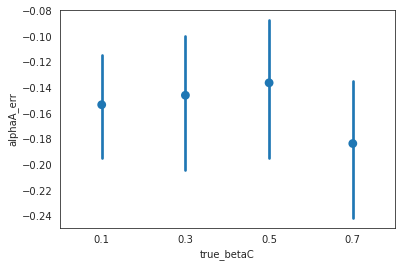

In [5]:
import seaborn as sns
sns.set_style('white')
sns.pointplot(x='true_betaC', y='alphaA_err', data=results_df, join=False)
# What % of the top ranked model in terms of alpha is correct?


### Improvements

- Incorporating outputted probabilities?
- Modeling how errors are likely correlated?